<h3 style="text-align:center"><em> Introduction to Solid State Physics: Computer Lab 1</em></h3>
<h1 style="text-align:center"> Vibrational properties of one-dimensional solids </h1>
<p style="text-align:center"><em>by Sébastien Lemal and Philippe Ghosez</em></p>

## I) Before we start...

### a) Purpose of the current lab

The objective of this session is to review the problem of harmonic vibrations in solids using a simple model: the 1-dimensional chain of atoms. In such a way, we retrains the number of degrees of freedom considerably while keeping a handful of significant physics. One-dimensional lattice can be as simple as the monoatomic chain of atoms, yet they can nevertheless becomes much more complex, with differents atoms (and interactions) within the Bravais lattice. Hence, even with simple 1D lattices, we often ends up with problems that cannot be solved easily. Moreover, letting the computer calculate the physical quantities and leaving humans performs more interesting tasks is a perfectly fine option.

<p>The current session deals with the following:
<ol>
    <li> A smaller reminder for the 1D monoatomic lattice</li>
    <li> Effects of second and third neighbours, and generalization</li>
    <li> The 1D diatomic lattice: solving the equations by diagonalization of the dynamical matrix</li>
    <li> The 1D triatomic lattice: witnessing the Brillouin zone folding using larger unit cells containing 3 atoms</li>
    <li> The 1D lattice: generalization for N atoms per unit cell: introduction to superlattices, and effects of point-defects</li>
</ol>
</p>

### b) Scripting with Python

For the sake of this session, we will run embedded Python scripts (<a href="https://www.python.org/">https://www.python.org/</a>). Python is an interpreted, high-level, general-purpose programming language which is quite popular amongst scientists, with its simple syntax and a large amount of libraries for scientific computing. Even if you are not familiar with Python, all the scripts below are already done, and the only thing you'll need to change is the value of some variables (used as parameters).


<p>Here are some comments about specific aspects of Python scripting:
<ul>
    <li> Some parameters will be stocked in arrays known as <i>lists</i> in Python, declared using <code>list_name = []</code>. For examples, the list of atoms of masses $M_i$ can be declared as <code>M = [1., 2.]</code>, which means that $M_1$ = 1 and $M_2$ = 2. Note that, similarly to C++, the index of arrays start at 0, meaning that <code>M[0] = 1</code>, <code>M[1] = 2</code>.</li>
    <li> We make use of the <a href="https://numpy.org/">NumPy</a> and <a href="https://www.scipy.org/">SciPy</a> libraries, providing useful functionalities for array manipulations and linear algebra applications. The results are plotted using the <a href="https://matplotlib.org/">MatPlotLib</a> library. These do not come with Python, yet have been installed on the server running this notebook.</li>
    <li>Loop can be performed using the <code>for</code> command (examples <a href="https://en.wikipedia.org/wiki/Foreach_loop#Python"> here</a>).</li>
    <li> As Python is interpreted, it may take some time before the results display. You can eventually tune the setting to limit the number of calculations, like tuning the number of k point where the dynamical matrix is diagonalized.</li>
    <li><span style="color: #ff0000;"><b> The scripts can be executed using Ctrl+Enter.</b></span></li>
</p>

## II) A small reminder: the 1D monoatomic lattice
We start by a small reminder about the vibrational properties of a 1D monoatomic lattice with atoms of mass $M$, linked between first neighbours with a stiffness constant $C$.

<img src="monoatomic_1D_lattice.svg" style="width: 50pc;"/>

The force applied to a single atom in cell $s$ is such as:

$$M\ddot u_s = C (u_{s-1} - u_{s})+ C(u_{s+1} - u_{s})$$
$$\Leftrightarrow M\ddot u_s = C (u_{s-1} + u_{s+1} - 2\:u_{s})$$

with atomic displacement

$$u_s = ue^{i(kx_s-\omega t)} = ue^{i(ksa-\omega t)}$$

where k is the wavevector ($k = 2\pi/\lambda$) and $\omega = 2\pi\nu$ the pulsation (frequency).

Injecting this solution in the equation of motion leads to

$$-M\omega^2u = C(e^{ika}+e^{-ika} -2)u$$

so that

$$\omega(k) = \sqrt{\frac{4C}{M}}\left|{\rm sin}{\left(\frac{ka}{2}\right)}\right|$$

which is the dispersion curve for the longitudinal vibration modes.

The analytical form of the density of state (DOS) for such a simple model can be easily derived:

$$DOS = g(\omega) = \frac{2}{\pi}\frac{1}{\sqrt{\omega_{max}^2 - \omega^2}}$$

where $\omega_{max}$ is the maximum pulsation (in the border of the Brillouin zone).
The DOS presents a singularity around the maximum value, known as Van Hove singularity. Toward $\omega$ $\rightarrow$ 0, the DOS converges toward $\frac{2}{\pi \omega_{max}}$

The following script plot the dispersion using the aforementioned analytical solution, as well as the associated density of state. The precision on the density depends on a number of parameters, such as the sampling in k-space and the interval of summation at a given $\omega$. In principle, convergence should be reached through an iterative process. As the sampling is finite, then the calculated DOS is finite.

Calculating the DOS...
Integrated DOS = 1.00



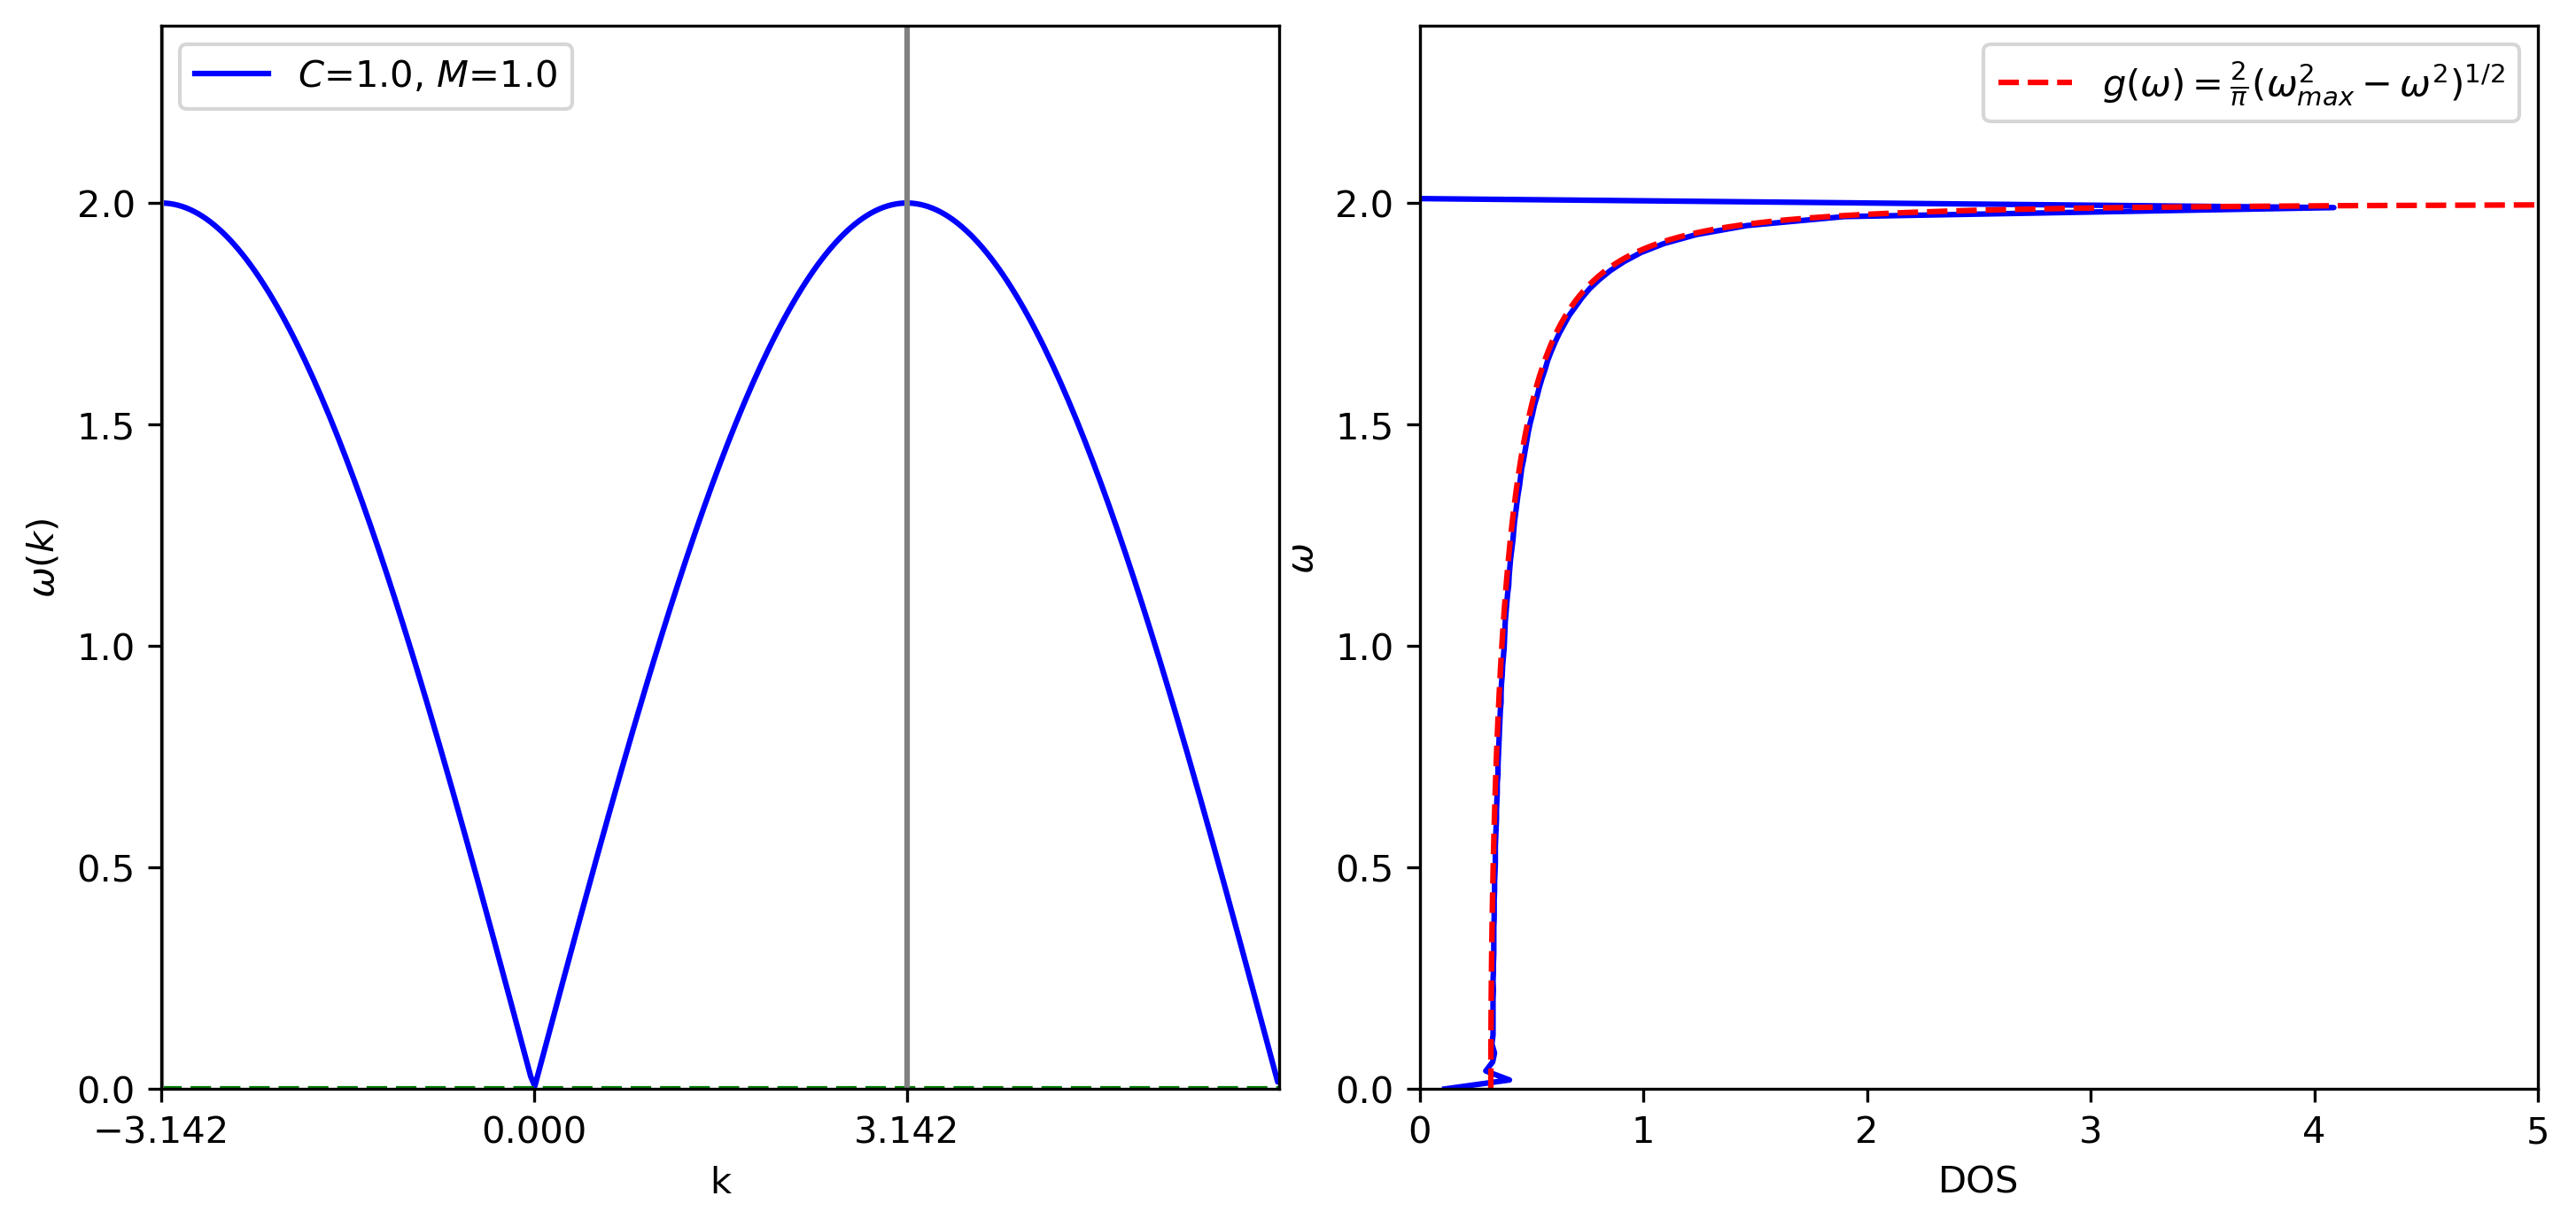

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from scipy import interpolate
import scipy.integrate as integrate
from numpy import linalg as LA
from pylab import *

# set parameters

a, M, C, N = 1., 1., 1., 1. 

def omega2(k):
    return (1/M)*(4*C*(np.sin(k*a/2)**2)) 

def dos_w(solution,N):
    # For each frequencies w, we integrate the number of state between w-dw and w+dw
    # Only the solution within the Brillouin zone must be provided
    solution_list = list(flatten(solution))

    dw = 2e-2
    w_space = np.linspace(-1e-5,max(solution_list)+1e-2, int(max(solution_list)/dw))
    w_dos = []

    for w in w_space:
        wsum = 0.
        for i in solution_list:
            if i > w-dw/2 and i < w+dw/2:
                wsum += 1
        w_dos.append(wsum) 

    # Normalize the DOS so that the integral is N (number of atoms in the cell)
    w_sum = sum(w_dos)*dw
    w_dos = w_dos/(w_sum/N)
    w_sum = sum(w_dos)*dw
    
    return w_space,w_dos,w_sum

nk = 1000 # Number of k-points

# Building a mesh in k-space to solve the dynamical matrix
kmesh, ibz, large_kmesh = np.linspace(-np.pi/a,10*np.pi/a,nk),\
                          np.linspace(-np.pi/a,np.pi/a,nk),\
                          np.linspace(-np.pi/a,np.pi/a,nk*30)
            
# Stocking the solutions, extrapolating the solutions, computing the DOS

dispersion = np.sqrt(omega2(kmesh))
exp_dispersion = interpolate.InterpolatedUnivariateSpline(kmesh, dispersion)
dispersion_ibz = interpolate.InterpolatedUnivariateSpline(ibz, dispersion)
max_w1 = max(list(flatten(dispersion)))
dos1 = [dos_w(dispersion_ibz(large_kmesh),1)[0],\
        dos_w(dispersion_ibz(large_kmesh),1)[1],\
        dos_w(dispersion_ibz(large_kmesh),1)[2]]

print('Calculating the DOS...')
print('Integrated DOS = ' + '%.2f'%(dos1[2]))

# Plotting the results

plt.figure(figsize=(12, 5), dpi=300) 

# Frequencies
plt.subplot(1,2,1,adjustable='datalim')
plt.plot(kmesh, dispersion,'b',\
         label='$C$=' + str(C) + ', $M$=' + str(M))
plt.plot(kmesh, kmesh*0,'g--')
plt.axvline(x=np.pi/a, c='gray')
plt.axvline(x=-np.pi/a, c='gray')
plt.xlabel(r'k')
plt.xlim(-np.pi/a,2*np.pi/a)
plt.xticks([-np.pi/a,0,np.pi/a]) #['$-\pi/a$','$0$', '$\pi/a$'])
plt.ylabel(r'$\omega (k)$')
plt.ylim(0,max_w1+(max_w1)/5)
plt.legend(loc='best')

# Density of state
plt.subplot(1,2,2,adjustable='datalim')
plt.plot(dos1[1], dos1[0],'b',linewidth=1.5)
w_sp =  np.linspace(0,max_w1-max_w1/1e12,1000)
plt.plot((2/np.pi)/np.sqrt(max_w1**2-(w_sp)**2) , w_sp,\
         'r--',linewidth=1.5,\
         label=r'$g(\omega) = \frac{2}{\pi}({\omega_{max}^2 - \omega^2})^{1/2}$')
plt.xlabel(r'DOS')
plt.xlim(0, 5)
plt.ylim(0,max_w1+(max_w1)/5)
plt.ylabel(r'$\omega$')
plt.legend(loc='best')
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.savefig("1D_atomic_chain_simple.pdf")

print ('')

## III) Applications

### a) Effects beyond nearest neighbours

In the precedent example, we only considered interaction between nearest neighbours. What if we consider interaction beyond, for example with 2nd neighbours?

<img src="monoatomic_1D_lattice_2nd_NN.svg" style="width: 50pc;"/>

The effects of second neighbours is easy to consider: we need to add the corresponding terms in the equation of motion:

$$M\ddot u_s = C_{1} (u_{s-1} - u_{s})+ C_{1}(u_{s+1} - u_{s}) + C_{2} (u_{s-2} - u_{s})+ C_{2}(u_{s+2} - u_{s})$$

leading to 

$$\omega(k) = \sqrt{\frac{1}{M}\left(4 C_1{\rm sin^2}{\left(\frac{ka}{2}\right)} + 4 C_2{\rm sin^2}{\left(ka\right)} \right)}$$

What about considering interactions up to to the 3rd neighbours ? Or the N-th neighbours ? The generalization is straightforward and exercises based on its analytic formulation are proposed in this course.

In the following script, we set a monoatomic 1D lattice with different configurations for the force constants ($C_1$ and $C_2$ sets). For $C_1$, we set the values [5, 0, 0], corresponding for the case where only the interactions between nearest neighbours are accounted (with $C$ = 5). For $C_2$, you may change the values to account the for second and third neighbours, for example [5, 2, 1]. 

#### <span style="color: #0000ff;">Exercises and questions</span>

<p><span style="color: #0000ff;">Using the script below, try to answer these questions:
<ol><span style="color: #0000ff;">
<li>Consider interactions up to the 2nd nearest neighbours. In which region(s) of the Brillouin zone do theses interactions have the largest effect ?</li>
<li>Consider interactions up to the 2nd nearest neighbours. What happens when the force constant between second neighbours has an opposite sign compare to the force constant between nearest neighbours ? Discuss.</li>
<li>Now add interactions between 3rd nearest neighbours. In which region(s) of the Brillouin zone do theses interactions have the largest effect ?</li>
<li>Set $C_1$ = 5, $C_2$ = $-C_1/4$ and $C_3$ = $C_1/4$. Describe what is happening.</li>
</span></ol>
</span> </p>

Calculating the DOS...
Integrated DOS = 1.00



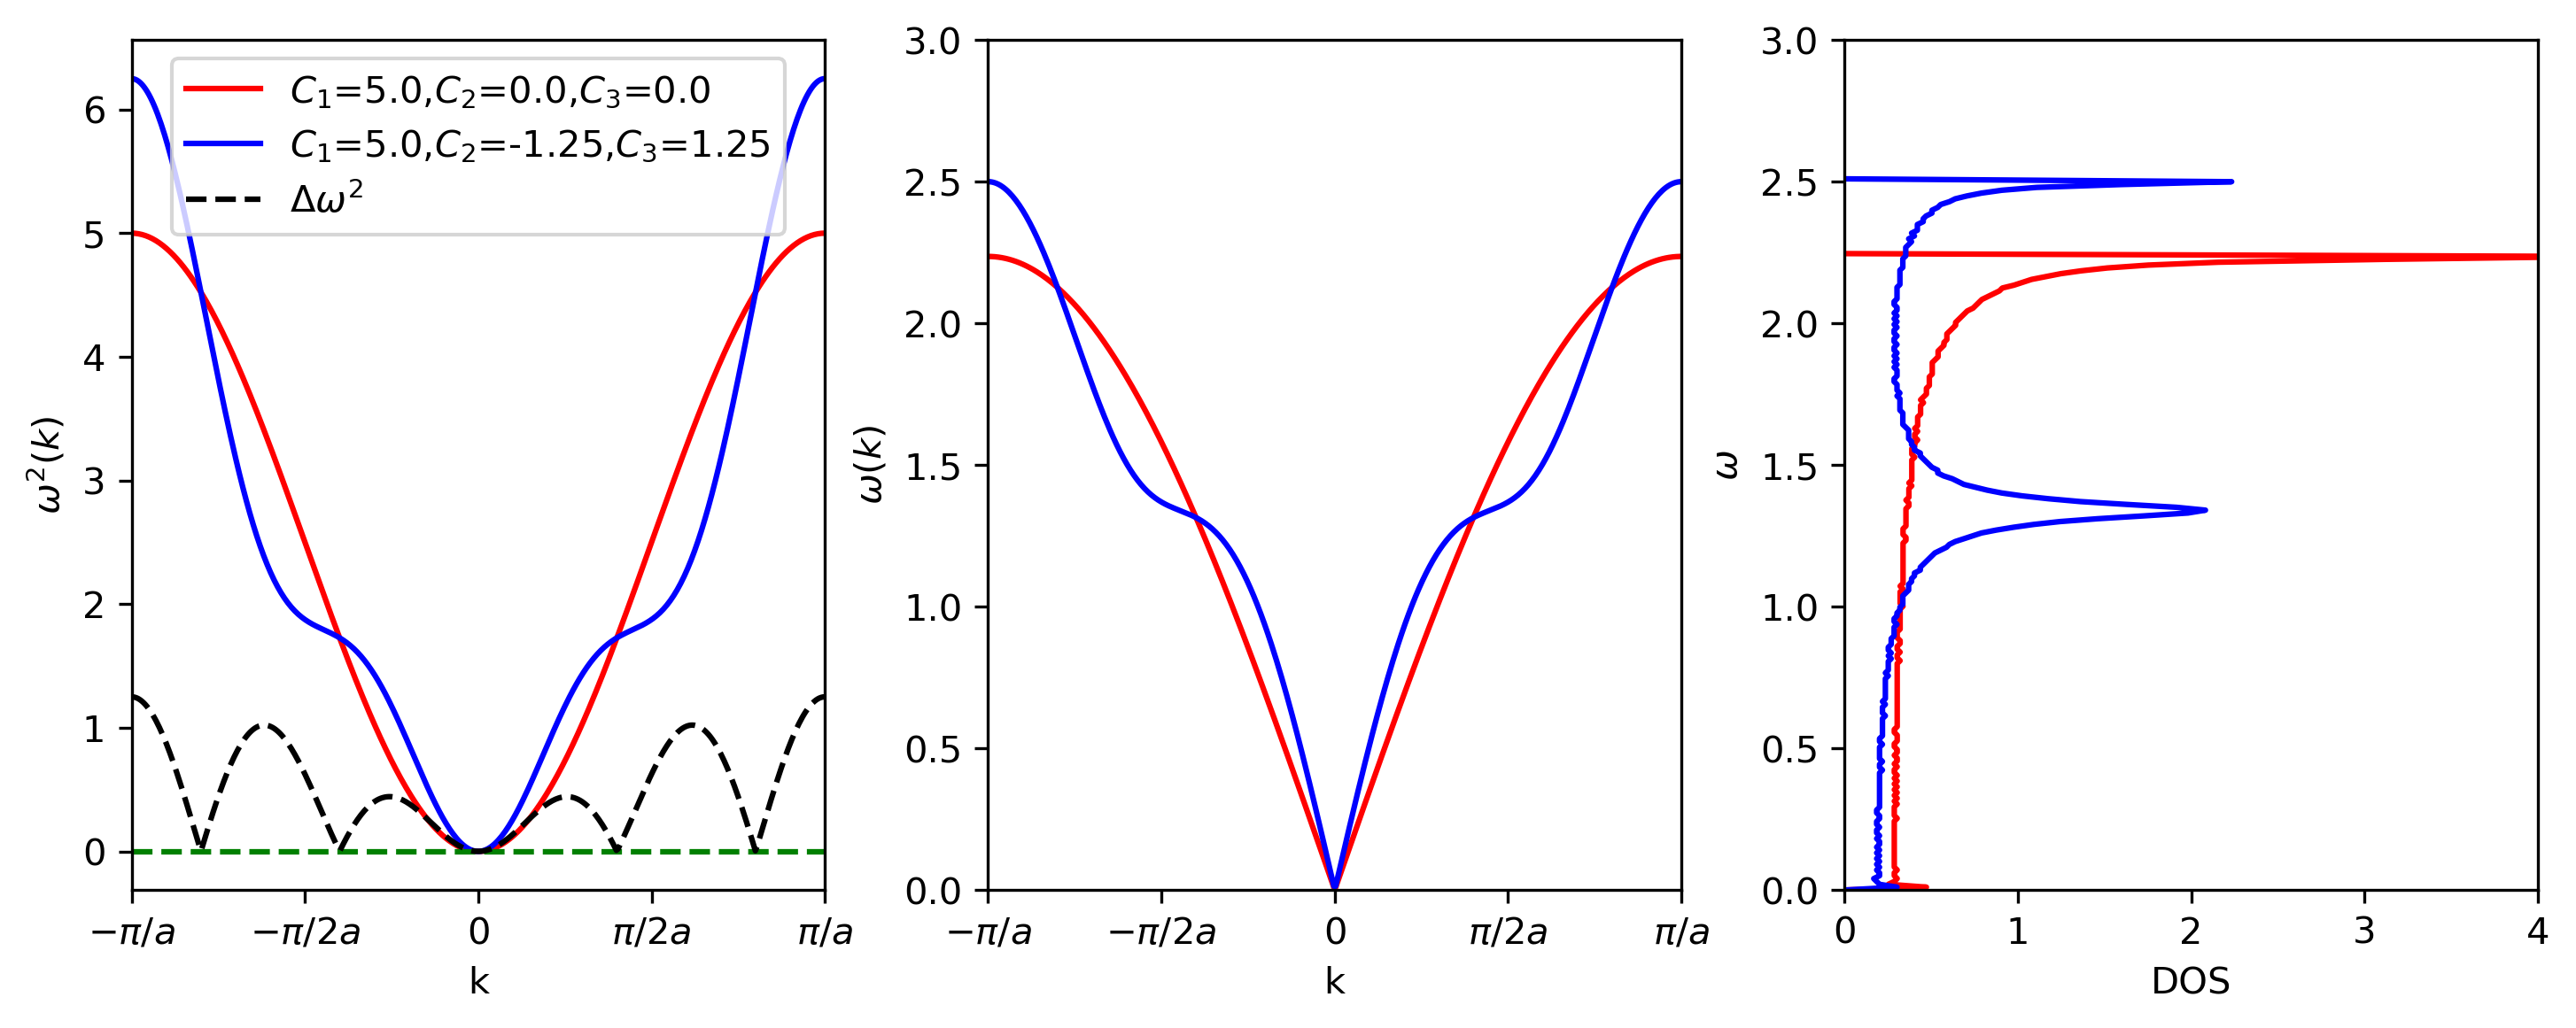

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from scipy import interpolate
import scipy.integrate as integrate
from numpy import linalg as LA
from pylab import *

# set parameters

a = 1. # cell parameter
M = [4.] # set M1 and M2

C1 = [5.,0.,0.]  # preset forces constants, in order C1, C2, C3, ...
C2 = [5.,-5./4,5./4]

C = C1 # Initialize force constants to the C1 configuration

number_of_atoms = len(M) # number of atoms
N =  len(C) # number of terms = number of force constants

def omega2(k):
    # Next we define the dynamic matrix accounting for all set interactions. 
    # The returned value is the squared frequency.
    ssum = (1/M[0])*(4*C[0]*(np.sin(k*a/2)**2))
    sqrtsum = 0.
    for i in range(N):
        if i >0:
            ssum = ssum+(1/M[0])*(4*C[i]*(np.sin((i+1)*k*a/2)**2))
    return (ssum) # return the square of frequency at a given k-point 

def dos_w(solution,N):
    # For each frequencies w, we integrate the number of state between w-dw and w+dw
    # Only the solution within the Brillouin zone must be provided
    solution_list = list(flatten(solution))

    dw = 1e-2
    w_space = np.linspace(1e-5,max(solution_list)+1e-2, int(max(solution_list)/dw))
    w_dos = []

    for w in w_space:
        wsum = 0.
        for i in solution_list:
            if i > w-dw/2 and i < w+dw/2:
                wsum += 1
        w_dos.append(wsum) 

    # Normalize the DOS so that the integral is N (number of atoms in the cell)
    w_sum = sum(w_dos)*dw
    w_dos = w_dos/(w_sum/N)
    w_sum = sum(w_dos)*dw
    
    return w_space,w_dos,w_sum

# Number of k-points
nk = 400

# Building a mesh in k-space to solve the dynamical matrix
kmesh, large_kmesh = np.linspace(-np.pi/a,np.pi/a,nk),\
                     np.linspace(-np.pi/a,np.pi/a,nk*30)

            
# Stocking the solutions, extrapolating the solutions, computing the DOS
C = C1
wsquare1, dispersion1 = omega2(kmesh), np.sqrt(omega2(kmesh))
exp_dispersion1 = interpolate.InterpolatedUnivariateSpline(kmesh, dispersion1)
max_w1 = max(list(flatten(dispersion1)))
dos1 = [dos_w(exp_dispersion1(large_kmesh),number_of_atoms)[0],\
        dos_w(exp_dispersion1(large_kmesh),number_of_atoms)[1],\
        dos_w(exp_dispersion1(large_kmesh),number_of_atoms)[2]]

C = C2
wsquare2, dispersion2 = omega2(kmesh), np.sqrt(omega2(kmesh))
exp_dispersion2 = interpolate.InterpolatedUnivariateSpline(kmesh, dispersion2)
max_w2 = max(list(flatten(dispersion2)))
print('Calculating the DOS...')
dos2 = [dos_w(exp_dispersion2(large_kmesh),number_of_atoms)[0],\
        dos_w(exp_dispersion2(large_kmesh),number_of_atoms)[1],\
        dos_w(exp_dispersion2(large_kmesh),number_of_atoms)[2]]           

print('Integrated DOS = ' + '%.2f'%(dos2[2]))

# Plotting the results

plt.figure(figsize=(12, 4), dpi=300)

# Eigenvalues
plt.subplot(1,3,1,adjustable='datalim')
C = C1
plt.plot(kmesh, wsquare1,'r',\
         label='$C_1$=' + str(C[0]) + ',$C_2$=' + str(C[1]) + ',$C_3$=' + str(C[2]))
C = C2
plt.plot(kmesh, wsquare2,'b',\
         label='$C_1$=' + str(C[0]) + ',$C_2$=' + str(C[1]) + ',$C_3$=' + str(C[2]))
plt.plot(kmesh, kmesh*0,'g--')
plt.plot(kmesh, abs(wsquare1-wsquare2),'k--', label='$\Delta\omega^2$')
plt.xlabel(r'k')
plt.xlim(-np.pi/a,np.pi/a)
plt.xticks([-np.pi/a,-np.pi/(2*a),0,np.pi/(2*a),np.pi/a],\
           ['$-\pi/a$','$-\pi/2a$','$0$','$\pi/2a$', '$\pi/a$'])
plt.ylabel(r'$\omega^2 (k)$')
plt.legend(loc='best')


# Frequencies
plt.subplot(1,3,2,adjustable='datalim')
plt.ylabel(r'$\omega (k)$')

C=C1
plt.plot(kmesh, dispersion1,'r',\
         label='$C_1$=' + str(C[0]) + ',$C_2$=' + str(C[1]) + ',$C_3$=' + str(C[2]))
C=C2
plt.plot(kmesh, dispersion2,'b',\
         label='$C_1$=' + str(C[0]) + ',$C_2$=' + str(C[1]) + ',$C_3$=' + str(C[2]))

plt.xlabel(r'k')
plt.xlim(-np.pi/a,np.pi/a)
plt.xticks([-np.pi/a,-np.pi/(2*a),0,np.pi/(2*a),np.pi/a],\
           ['$-\pi/a$','$-\pi/2a$','$0$','$\pi/2a$', '$\pi/a$'])
plt.ylim(0,max_w2+0.5)

# Density of state
plt.subplot(1,3,3,adjustable='datalim')
plt.plot(dos1[1], dos1[0],'r') # linewidth=2
plt.plot(dos2[1], dos2[0],'b')
plt.xlabel(r'DOS')
plt.xlim(0,4)
plt.ylim(0,max_w2+0.5)
plt.ylabel(r'$\omega$')
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.savefig("1D_atomic_chain_with_interaction_beyond_NN.pdf")

print ('')

###  b) A one-dimensional lattice with 2-atoms unit cell

Let us consider a 1D lattice with a 2-atoms pattern, as follows:

<img src="diatomic_1D_lattice.svg" style="width: 50pc;"/>

We consider two atoms with masses $M_1$ and $M_2$, bonded through force constants $C_1$ and $C_2$. Thus, the interactions are limited between nearest neighbours.
The equations of motion for the atoms in cell $s$ are:

$$\begin{cases}
M_1\ddot u_s = C_{2} (v_{s-1} - u_{s})+ C_{1}(v_{s} - u_{s})\\
M_2\ddot v_s = C_{2} (u_{s+1} - v_{s})+ C_{1}(u_{s} - v_{s})
\end{cases}$$

Using the <i>ansatz</i> $\displaystyle u_s = u\:e^{i(ksa -\omega t)}$, $\displaystyle v_s = v\:e^{i(ksa -\omega t)}$, we have the following equations:

$$\begin{array}{lcl} 
0 & = &\left[C_1 + C_2 - M_1\omega^2 \right]u - \left[C_1 + C_2\: e^{-ika}\right]v \\
0 & = & -\left[C_1 + C_2\: e^{ika}\right]u + \left[C_1 + C_2 - M_2\omega^2 \right]v \end{array}$$

This system of equation admits solutions if:

$$\displaystyle
\begin{vmatrix}
C_1 + C_2 - M_1\omega^2 & -[C_1 + C_2\: e^{-ika}]\\
-[C_1 + C_2\: e^{ika}] & C_1 + C_2 - M_2\omega^2
\end{vmatrix} = 0$$

Calculating the determinant of this matrix and finding the roots leads to the solution $\omega_i(k)$.

Another way is to rewrite the equations as:

$$\displaystyle
\begin{pmatrix}
\displaystyle \frac{1}{M_1}(C_1 + C_2) &\displaystyle -\frac{1}{M_1}[C_1 + C_2\: e^{-ika}]\\
\displaystyle-\frac{1}{M_2}[C_1 + C_2\: e^{ika}] &\displaystyle \frac{1}{M_2}(C_1 + C_2)
\end{pmatrix}
\begin{pmatrix}
u\\
v
\end{pmatrix}= \omega^2
\begin{pmatrix}
u\\
v
\end{pmatrix}$$

$$\Longleftrightarrow \tilde{\mathbf{D}}\cdot\mathbf{U} = \omega^2 \mathbf{U}$$

This is a basic eigenvalues problem: the matrix $\tilde{\mathbf{D}}$ is called dynamical matrix, and its eigenvalues corresponds to the frequencies $\omega_i(k)$, whereas the eigenvectors $\mathbf{U} = (u,v)$ are the associated displacements.

Hence, diagonalizing the dynamical matrix is all one need to do in order to get the solutions $\omega_i(k)$. In the case of the diatomic lattice, it is straightforward to do so. For more complex lattices however, it is often impossible to obtain analytical results, hence the necessity to solve the problem numerically. In this lab, we choose this option, using a linear algebra module included in the <code>scipy</code> libraries.
The following script performs such a diagonalization over several k-points in order to get the dispersion curves. The script is divided into several part:

<ol>
<li>First, we set the parameters ($M_1$, $M_2$, $C_1$, $C_2$, and the lattice parameter $a$)</li>
<li>We then define two functions: one returns the dynamical matrix for a given wave number $k$ (<code>dyn_mat_2at(k)</code>), whereas the other return the density of state (DOS) for the solutions $\omega_i(k)$ (<code>dos_w(solution,N)</code>)</li>
    <li>Then, we solve the problem using a linear algebra module to diagonalize the dynamical matrix over all the k-points in our mesh (using <code>LA.eigvals(dyn_mat_2at(k))</code>), and we also compute the DOS associated to these results.</li>
<li>Finally, these results are plotted using the <code>matplotlib</code> library.</li>
</ol>

#### <span style="color: #0000ff;">Exercises and questions</span>

<p><span style="color: #0000ff;">Using the script below, try to answer these questions:</span> </p>
<ol><span style="color: #0000ff;">
<li>Set $C_1$ = $C_2$ = 5, $M_1$ = $M_2$ = 3. What do you get ?</li>
<li>Change $C_2$ and $M_2$. What is happening ? Describe the density of state.</li>
<li>Identify the acoustic and optic branches.</li>
<li>Now, try to adapt the script below so that interactions up to the second nearest neighbours are accounted. What is the associated dynamical matrix ? Emphasize the effects from the second nearest neighbours and plot what you get.</li>
</span></ol>
</span> </p>

2 atoms in the cell -> 2 bands along k.

M = [2.0, 3.0]
C = [1.0, 2.0]

Dynamical matrix at Gamma (k = 0):
[[ 1.5       +0.j -1.22474487+0.j]
 [-1.22474487+0.j  1.        +0.j]]

The corresponding eigenvalues w^2 are:
[-1.11022302e-16  2.50000000e+00]

The corresponding eigenvectors are:
[[-0.63245553-0.j -0.77459667+0.j]
 [-0.77459667-0.j  0.63245553+0.j]]


Calculating the DOS...
Integrated DOS = 2.00



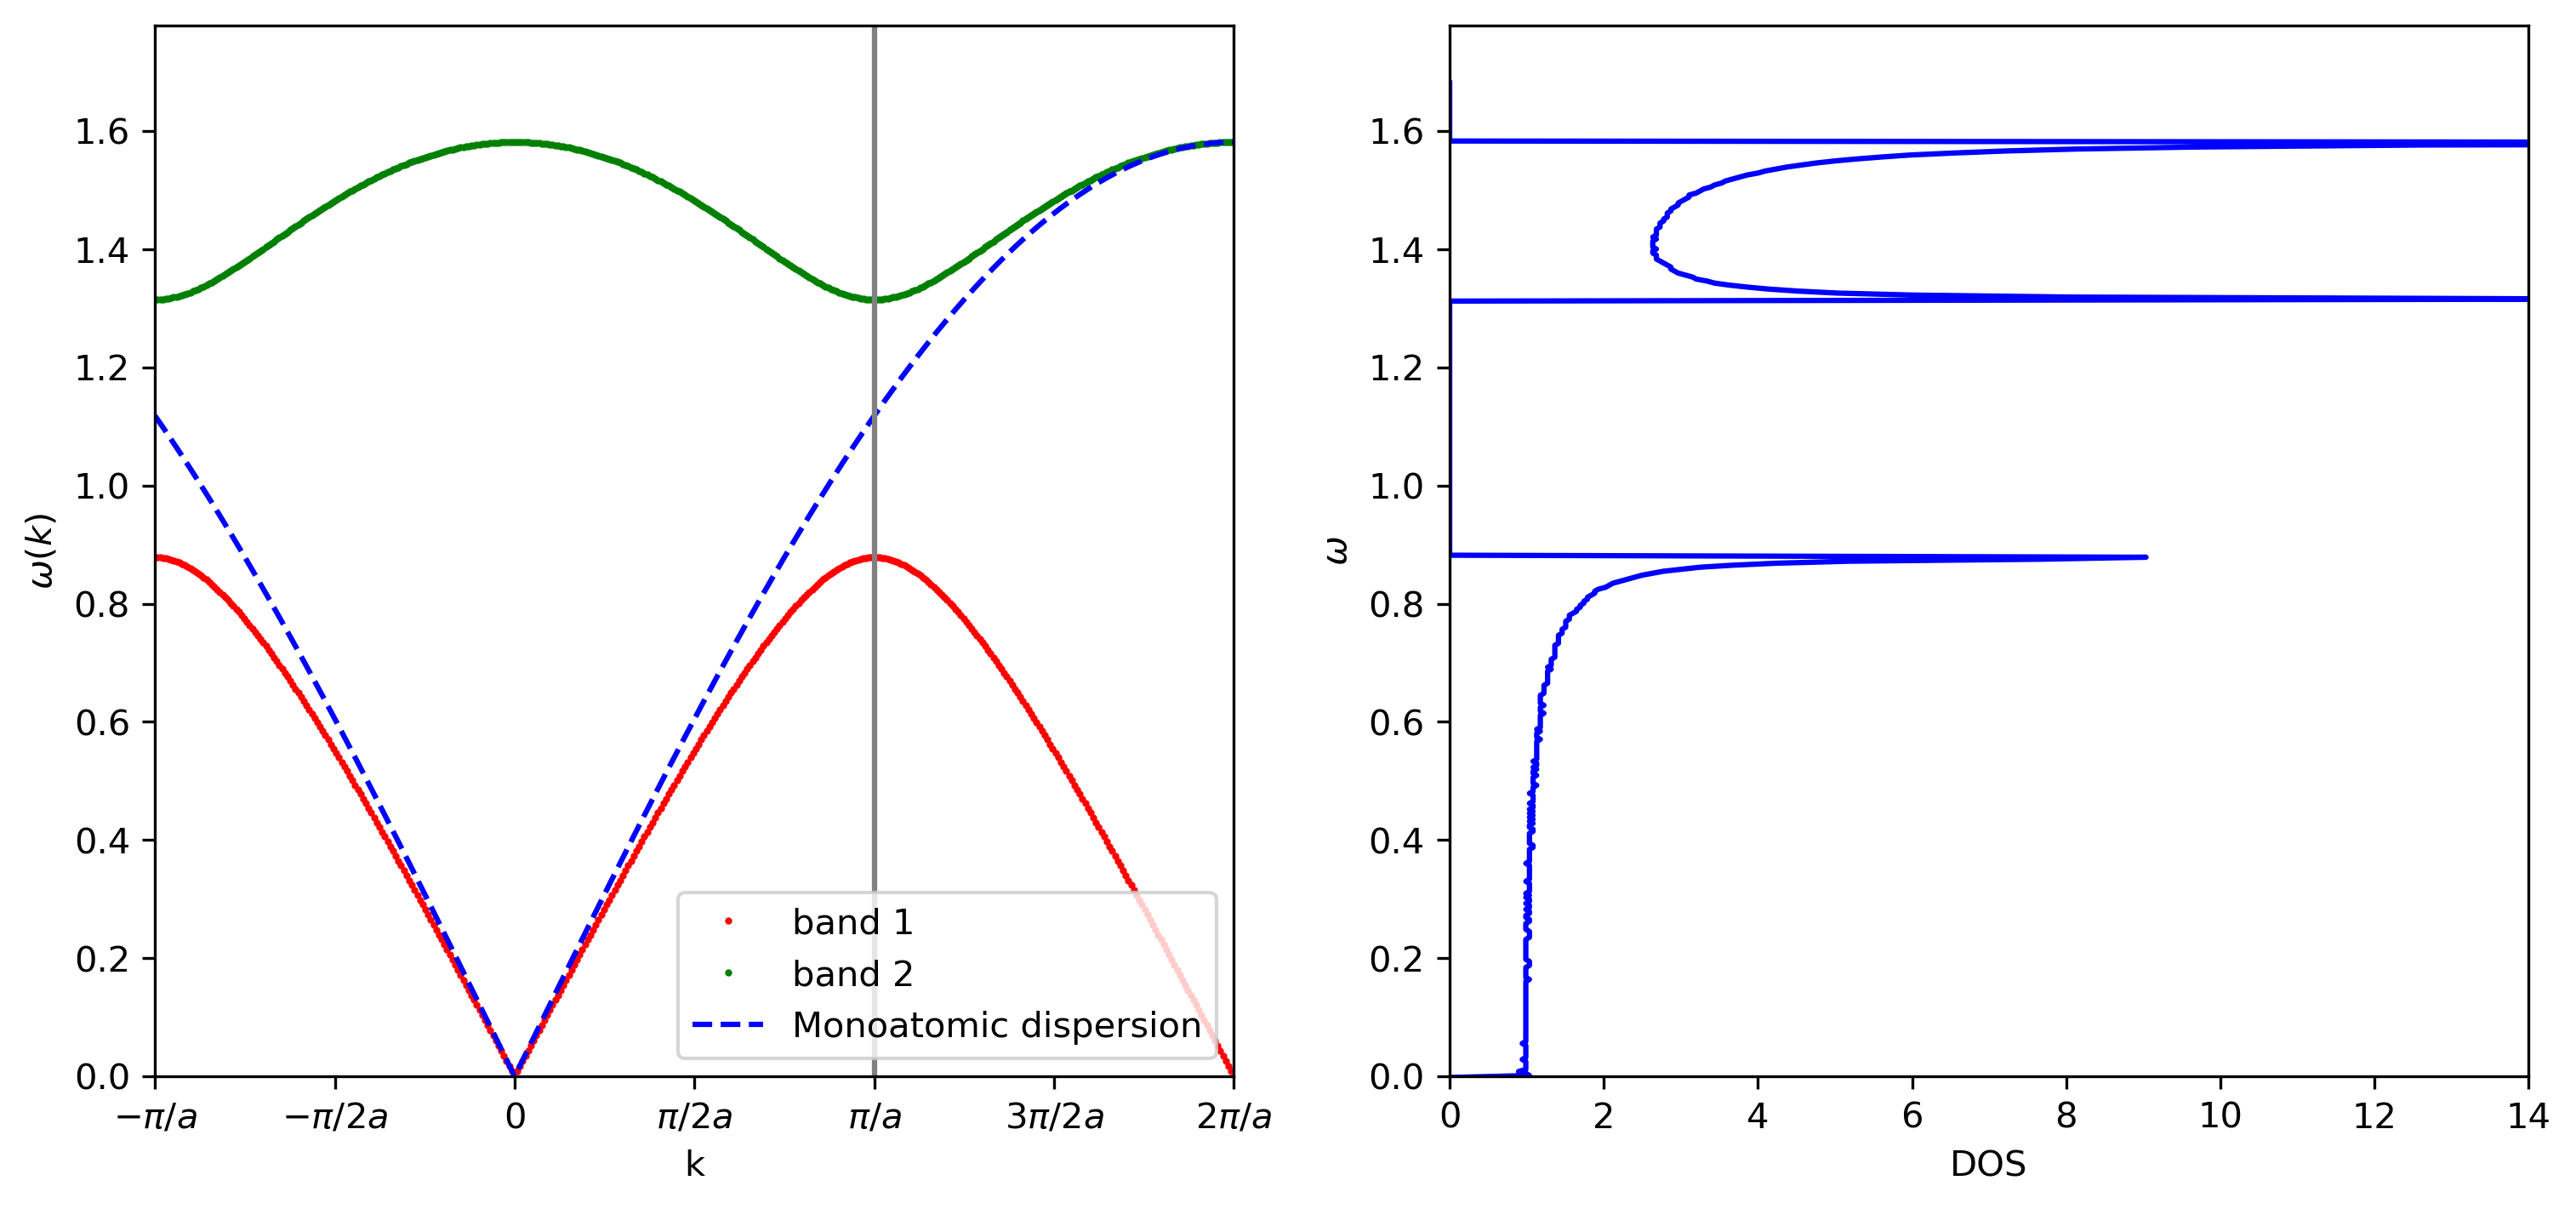

In [5]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize.nonlin import BroydenFirst, KrylovJacobian
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from numpy import linalg as LA
from pylab import *

########################################
#                                      #
#        Part 1: set parameters        #
#                                      #
########################################

M = [2.,3.] # set M1 and M2
C = [1.,2.] # set C1 and C2
a = 1. # cell parameter
N = len(M) 

print (str(N) + " atoms in the cell -> 2 bands along k." + '\n')
print ('M = ' + str(M) + '\n' + 'C = ' + str(C) + '\n')

########################################
#                                      #
#      Part 2: functions returning     #
#   the dynamical matrix and the DOS   #
#                                      #
########################################

def dyn_mat_2at(k):
    return np.array([[(C[0]+C[1])/M[0], (-1/np.sqrt(M[0]*M[1]))*(C[0] + C[1]*np.exp(-1.j*k*a))],\
                     [(-1/np.sqrt(M[0]*M[1]))*(C[0] + C[1]*np.exp(1.j*k*a)), (C[0]+C[1])/M[1]]],\
                    dtype=complex)

def dos_w(solution,N):
    # For each frequencies w of a given solution (eigenvalues), 
    # we integrate the number of state between w-dw and w+dw
    # Only the solution within the Brillouin zone must be provided
    solution_list = list(flatten(solution))

    dw = 3e-3
    w_space = np.linspace(-0.1,max(solution_list)+0.1,int(max(solution_list)/dw))
    w_dos = []

    for w in w_space:
        wsum = 0.
        for i in solution_list:
            if i > w-dw/2 and i < w+dw/2:
                wsum += 1
        w_dos.append(wsum)  
        
    # Normalize the DOS so that the integral over the Brillouin zone is N !
    w_sum = sum(w_dos)*dw
    w_dos = (w_dos/(w_sum/N))
    w_sum = sum(w_dos)*dw

    return w_space,w_dos,w_sum

print ('Dynamical matrix at Gamma (k = 0):')
print (dyn_mat_2at(0))
print ('\nThe corresponding eigenvalues w^2 are:')
print (LA.eigh(dyn_mat_2at(0))[0])
print ('\nThe corresponding eigenvectors are:')
print (LA.eigh(dyn_mat_2at(0))[1])
print ('\n')


########################################
#                                      #
#      Part 3: diagonalizing the       #
#   dynamical matrix on a mesh in      #
#    k-space and computing the DOS     #
#  using the eigenvalues restricted to #
#      the first Brillouin zone        #
#                                      #
########################################

nk = 400 # Number of k-points

kmesh = np.linspace(-1*np.pi,2*np.pi,nk) # Building a k-mesh in k-space to solve the dynamical matrix

# building the array where the solutions will be stocked
# Due to numerical accurary issues, some solutions at a given k-point will be "Not a number" (NaN).
# These are rejected, and we use the k-points without any pathologies for the mesh.

eigenvalues, eigenvectors, kokay = [], [], []
for i in range(N):
    eigenvalues.append([])
    eigenvectors.append([])
    kokay.append([])
    
#Diagonalization of the dynamical matrix for each k points. 
#The number of solutions is equal to N for a 1D system.
#We only take the positive roots.

for i in range(N):
    for k in kmesh:
        n = LA.eigh(dyn_mat_2at(k))
        if np.real(n[0][i]) > 0:  
            eigenvalues[i].append(np.sqrt(np.real(n[0][i])))
            eigenvectors[i].append((np.real((n[1]))))
            kokay[i].append(k)

# Calculation the DOS: the previous step are performed again, only within the Brillouin zone

print('Calculating the DOS...')

ibz, large_ibz = np.linspace(-np.pi/a,np.pi/a,nk), np.linspace(-np.pi/a,np.pi/a,nk*40)
eigenvalues_ibz, kokay_ibz  = [], []
for i in range(N):
    eigenvalues_ibz.append([])
    kokay_ibz.append([])

for i in range(N):
    for k in ibz:
        n = LA.eigvalsh(dyn_mat_2at(k))
        if np.real(n[i]) > 0:  
            eigenvalues_ibz[i].append(np.sqrt(np.real(n[i])))
            kokay_ibz[i].append(k)

# We expand the solution to more k-points by interpolation
exp_eigenvalues_ibz = eigenvalues_ibz
for i in range(N):
    s = interpolate.InterpolatedUnivariateSpline(kokay_ibz[i], eigenvalues_ibz[i])
    exp_eigenvalues_ibz[i] = s(large_ibz)

max_w = max(list(flatten(eigenvalues_ibz)))
      
results_dos = [dos_w(exp_eigenvalues_ibz,N)[0],\
               dos_w(exp_eigenvalues_ibz,N)[1],\
               dos_w(exp_eigenvalues_ibz,N)[2]]

print('Integrated DOS = ' + '%.2f'%(results_dos[2]))

########################################
#                                      #
#     Part 4: Plotting the results     #
#                                      #
########################################

plt.figure(figsize=(12, 12), dpi=300) 
plt.subplot(2,2,1,adjustable='datalim')

plt.plot(kokay[0],eigenvalues[0],'ro',ms=1., label='band ' + str(1))
plt.plot(kokay[1],eigenvalues[1],'go',ms=1., label='band ' + str(2))
plt.plot(kmesh,np.sqrt((C[0]+C[1])*(M[0]+M[1])/(M[0]*M[1]))*abs(np.sin(kmesh*a/4)),\
         'b--',label='Monoatomic dispersion')
    
plt.xlabel(r'k')
plt.xticks([-np.pi/a,-np.pi/(2*a),0,np.pi/(2*a),np.pi/a, (1.5)*np.pi/a, 2*np.pi/a],\
           ['$-\pi/a$','$-\pi/2a$','$0$','$\pi/2a$', '$\pi/a$', '$3\pi/2a$', '$2\pi/a$'])
plt.xlim(-np.pi/a,2*np.pi/a)
plt.axvline(x=np.pi/a, c='gray')
plt.ylabel(r'$\omega (k)$')
plt.ylim(0,max_w+max_w/8)
plt.legend(loc='best')

plt.subplot(2,2,2,adjustable='datalim')
plt.xlabel(r'DOS')
plt.ylabel(r'$\omega$')
plt.ylim(0,max_w+max_w/8)
plt.xlim(0,14)
plt.plot(results_dos[1], results_dos[0], 'b', ms= 0.5)
plt.savefig("1D_diatomic_chain_vibrations.pdf")

print ('')

### c) The one-dimensional lattice with a 3-atoms unit cell

We will now work on a slightly more complex model, which is the triatomic 1D lattice. In the unit cell, there are 3 atoms of mass $M_1$, $M_2$ and $M_3$, which are bonded through force constants $C_1$, $C_2$ and $C_3$.

$$\begin{cases}\displaystyle
M_1\ddot u_s = C_{3} (z_{s-1} - u_{s})+ C_{1}(v_{s} - u_{s})\\
M_2\ddot v_s = C_{2} (z_{s} - v_{s})+ C_{1}(u_{s} - v_{s})\\
M_3\ddot z_s = C_{3} (u_{s+1} - z_{s})+ C_{2}(v_{s} - z_{s})
\end{cases}$$

Using the usual ansatz for the displacements, we get the eigenvalues problems:

$$\tilde{\mathbf{D}}\cdot \mathbf{U} = \omega^2 \mathbf{U}$$

where $\mathbf{U} = (u,v,z)$ and 

$$\displaystyle \tilde{\mathbf{D}} = 
\begin{pmatrix}
\displaystyle\frac{C_{1}+C_{3}}{\sqrt{M_1}\sqrt{M_1}} &\displaystyle \frac{-C_{1}}{\sqrt{M_1}\sqrt{M_2}} &\displaystyle \frac{-C_{3}e^{-ika}}{\sqrt{M_1}\sqrt{M_3}}\\
\displaystyle \frac{-C_{1}}{\sqrt{M_2}\sqrt{M_1}} &\displaystyle \frac{C_{1}+C_{2}}{\sqrt{M_2}\sqrt{M_2}} &\displaystyle \frac{-C_{2}}{\sqrt{M_2}\sqrt{M_3}}\\
\displaystyle\frac{-C_{3}e^{ika}}{\sqrt{M_3}\sqrt{M_1}} &\displaystyle \frac{-C_{2}}{\sqrt{M_3}\sqrt{M_2}} &\displaystyle \frac{C_{2}+C_{3}}{\sqrt{M_3}\sqrt{M_3}}
\end{pmatrix}$$



#### <span style="color: #0000ff;">Exercises and questions</span>

<p><span style="color: #0000ff;">Using the script below, try to answer these questions:</span> </p>

<ol><span style="color: #0000ff;">
<li>Set $C_1$ = $C_2$  = $C_3$ = 1, and $M_1$ = $M_2$ = $M_3$ = 1. What do you get ?</li>
<li>Set $C_3$ = 2. What do you get ?</li>
</span></ol>

M = [1.0, 1.0, 2.0]
C = [1.0, 1.0, 1.0]

Dynamical matrix at Gamma (k = 0):
[[ 2.        +0.j -1.        +0.j -0.70710678+0.j]
 [-1.        +0.j  2.        +0.j -0.70710678+0.j]
 [-0.70710678+0.j -0.70710678+0.j  1.        +0.j]]

The corresponding eigenvalues w^2 are:
[[-5.00000000e-01+0.j  5.00000000e-01-0.j  7.07106781e-01+0.j]
 [-5.00000000e-01+0.j  5.00000000e-01+0.j -7.07106781e-01+0.j]
 [-7.07106781e-01+0.j -7.07106781e-01+0.j  1.11022302e-16+0.j]]


Calculating the DOS...
Integrated DOS = 3.00



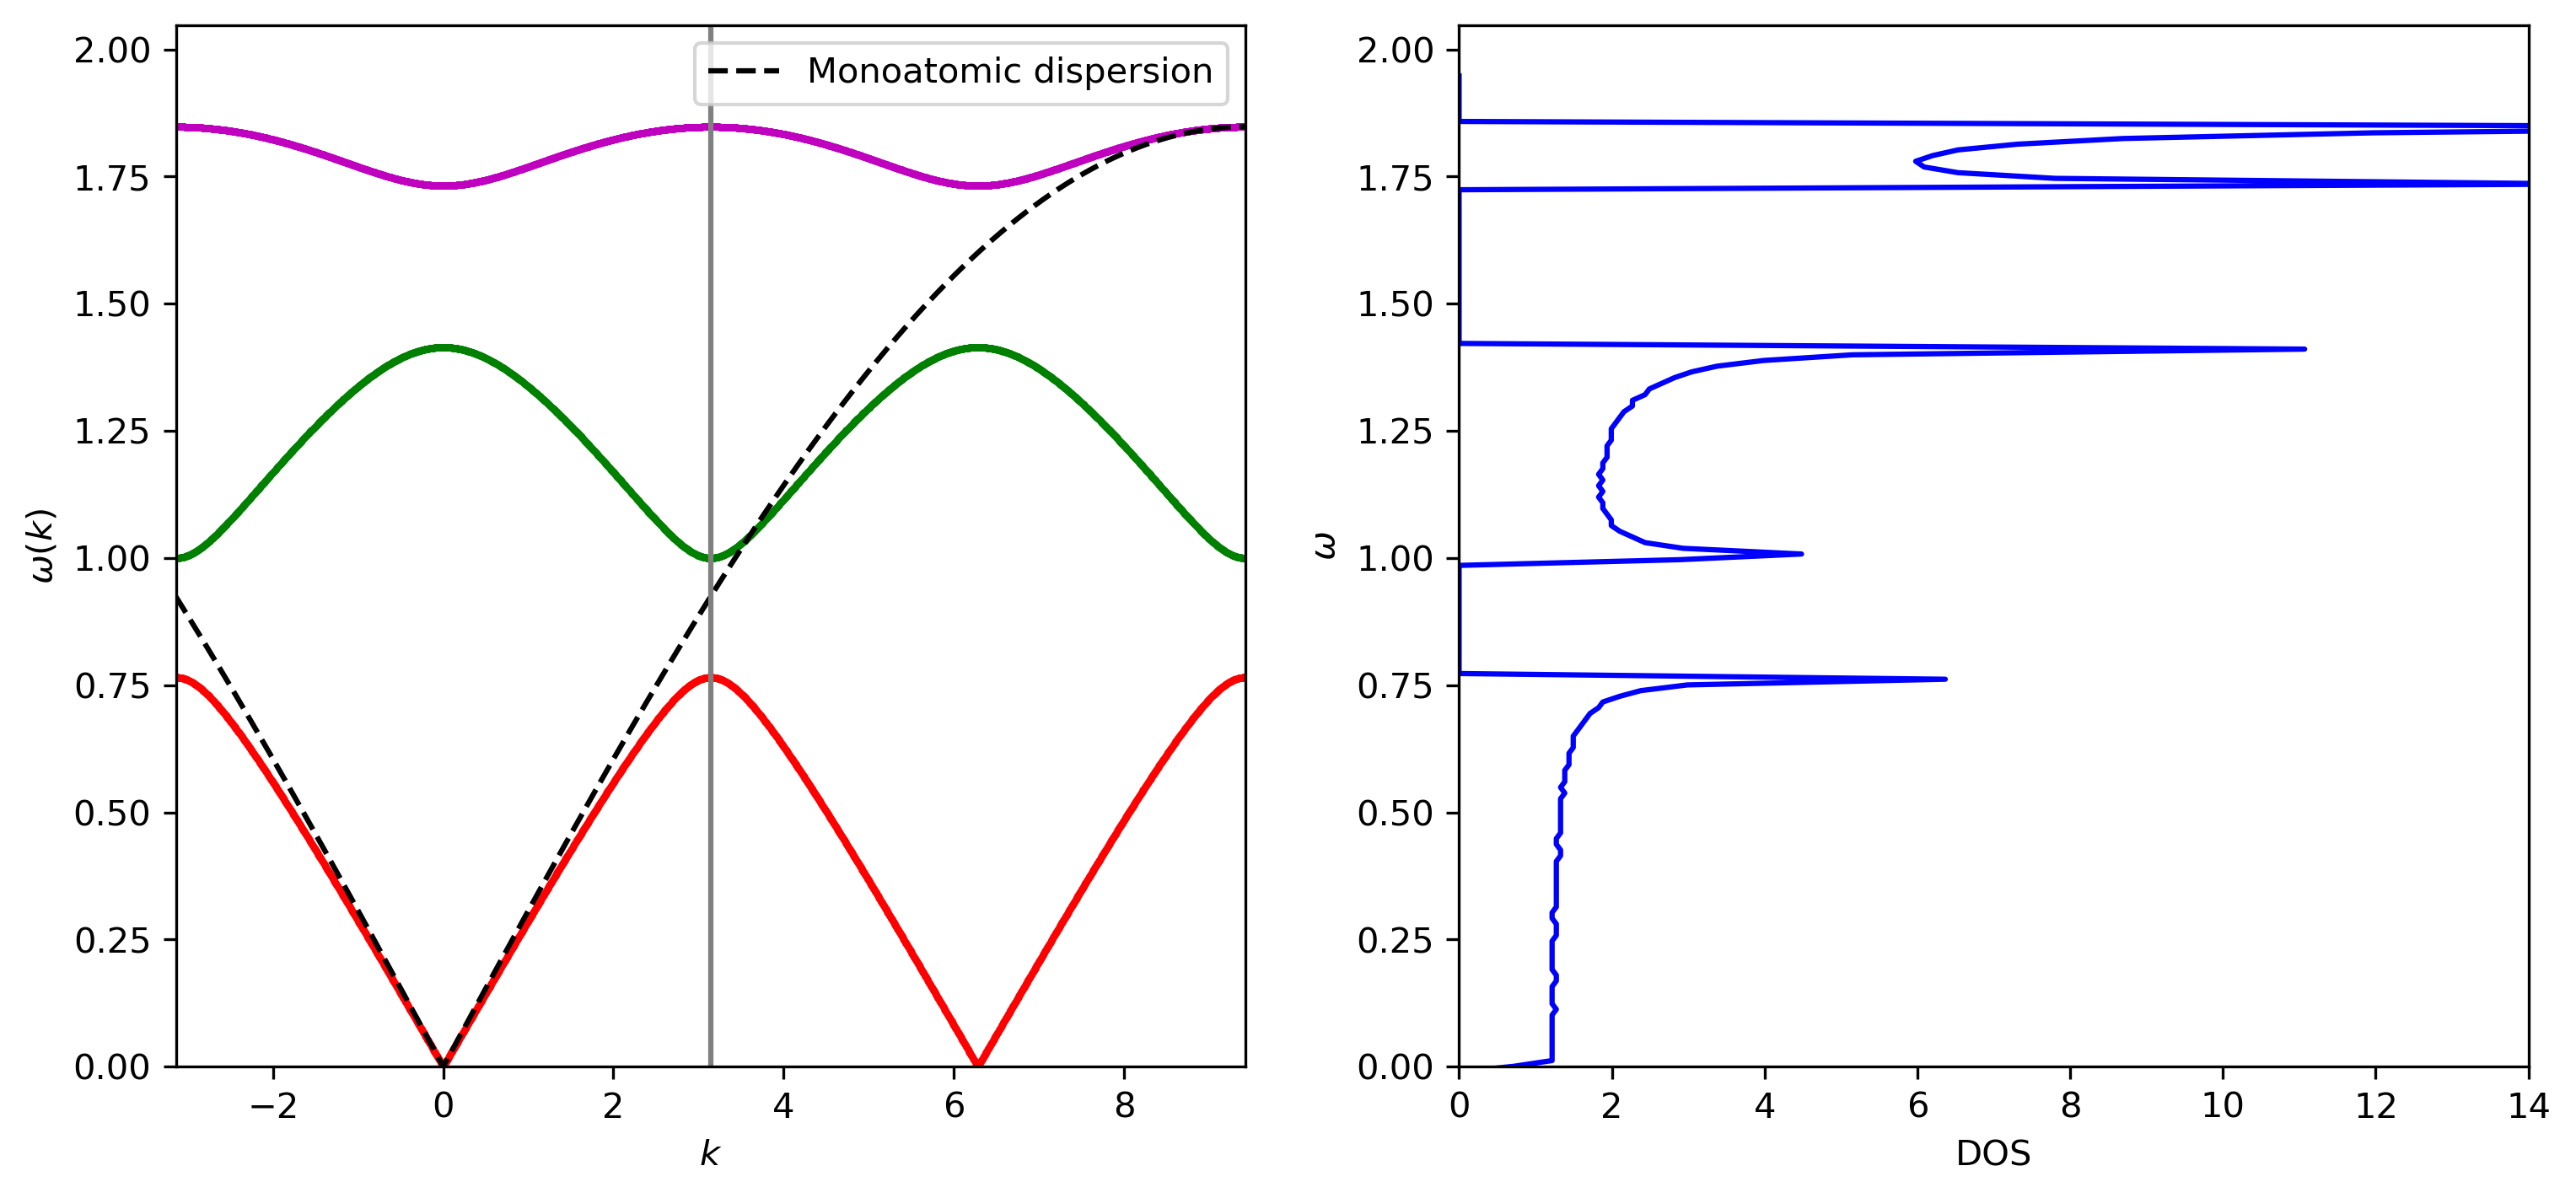

In [4]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize.nonlin import BroydenFirst, KrylovJacobian
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from numpy import linalg as LA
from pylab import *

########################################
#                                      #
#        Part 1: set parameters        #
#                                      #
########################################

M = [1.,1.,2.]
C = [1.,1.,1.]

a = 1. # cell parameter

print ('M = ' + str(M) + '\n' + 'C = ' + str(C) + '\n')

N = len(M) 

########################################
#                                      #
#      Part 2: functions returning     #
#   the dynamical matrix and the DOS   #
#                                      #
########################################

def dyn_mat_3at(k):
    return np.array([[(C[0]+C[2])/np.sqrt(M[0]*M[0]), -C[0]/np.sqrt(M[0]*M[1]), (-1/np.sqrt(M[0]*M[2]))*(C[2]*np.exp(-1.j*k*a))], \
                     [-C[0]/np.sqrt(M[0]*M[1]), (C[0]+C[1])/(np.sqrt(M[1]*M[1])), -C[1]/np.sqrt(M[2]*M[1])] , \
                     [(-1/np.sqrt(M[0]*M[2]))*(C[2]*np.exp(1.j*k*a)), -C[1]/np.sqrt(M[1]*M[2]),(C[1]+C[2])/np.sqrt(M[2]*M[2])]], dtype=complex)

def dos_w(solution,N):
    # For each frequencies w, we integrate the number of state between w-dw and w+dw
    # Only the solution within the Brillouin zone must be provided
    solution_list = list(flatten(solution))

    dw = 1e-2
    w_space = np.linspace(-0.1,max(solution_list)+0.1,int(max(solution_list)/dw))
    w_dos = []

    for w in w_space:
        wsum = 0.
        for i in solution_list:
            if i > w-dw/2 and i < w+dw/2:
                wsum += 1
        w_dos.append(wsum)      

    # Normalize the DOS so that the integral over the Brillouin zone is N !
    w_sum = sum(w_dos)*dw
    w_dos = w_dos/(w_sum/N)
    w_sum = sum(w_dos)*dw
    return w_space,w_dos, w_sum

print ('Dynamical matrix at Gamma (k = 0):')
print (dyn_mat_3at(0))
print ('\nThe corresponding eigenvalues w^2 are:')
toto = LA.eigh(dyn_mat_3at(0))
print (toto[1])
print ('\n')

########################################
#                                      #
#      Part 3: diagonalizing the       #
#   dynamical matrix on a mesh in      #
#    k-space and computing the DOS     #
#  using the eigenvalues restricted to #
#      the first Brillouin zone        #
#                                      #
########################################

# number of points
nk = 4000

# k points
kmesh = np.linspace(-N*np.pi/a,N*np.pi/a,nk)

eigenvalues, kokay = [],[]
for i in range(N):
    eigenvalues.append([])
    kokay.append([])
    
#complex_mat = np.array([1, 2, 3], dtype=complex)s
#print (complex_mat)

for i in range(N):
    for k in kmesh:
        n = LA.eigh(dyn_mat_3at(k))
        if np.real(n[0][i]) > 0:
            eigenvalues[i].append(np.sqrt(np.real(n[0][i])))
            kokay[i].append(k)

# Calculation the DOS

print('Calculating the DOS...')

ibz, eigenvalues_ibz, kokay_ibz =   np.linspace(-np.pi/a,np.pi/a,nk), [], []

for i in range(N):
    eigenvalues_ibz.append([])
    kokay_ibz.append([])

for i in range(N):
    for k in ibz:
        n = LA.eigvalsh(dyn_mat_3at(k))
        n = np.sort(n, axis=None)
        if np.real(n[i]) > 0:  
            eigenvalues_ibz[i].append(np.sqrt(np.real(n[i])))
            kokay_ibz[i].append(k)

max_w = max(list(flatten(eigenvalues_ibz)))

results_dos = [dos_w(eigenvalues_ibz,N)[0],dos_w(eigenvalues_ibz,N)[1],dos_w(eigenvalues_ibz,N)[2]]            

print('Integrated DOS = ' + '%.2f'%(results_dos[2]))
       
########################################
#                                      #
#     Part 4: Plotting the results     #
#                                      #
########################################
    
plt.figure(figsize=(12, 12), dpi=300) 
plt.subplot(2,2,1,adjustable='datalim')

plt.plot(kokay[0],eigenvalues[0],'ro', ms = 1)
plt.plot(kokay[1],eigenvalues[1],'go', ms = 1)
plt.plot(kokay[2],eigenvalues[2],'mo', ms = 1)
plt.plot(kmesh, max_w*abs(np.sin(kmesh*a/(2*N))),'k--', label='Monoatomic dispersion')

plt.xlim(-np.pi,np.pi)
plt.xlabel(r'$k$')
plt.ylabel(r'$\omega (k)$')
plt.ylim(0,max_w+0.2)
plt.xlim(-np.pi/a,3*np.pi/a)
plt.axvline(x=np.pi/a, c='gray')
plt.legend(loc='best')

plt.subplot(2,2,2,adjustable='datalim')
plt.xlabel(r'DOS')
plt.ylabel(r'$\omega$')
plt.ylim(0,max_w+0.2)
plt.xlim(0,14)
#plt.fill_between(w_dos, w_space, w_dos)
plt.plot(results_dos[1],results_dos[0], 'b', ms= 0.5)
plt.savefig("1D_triatomic_chain_vibrations.pdf")

print ('')

### d) The one-dimensional lattice with  a many atoms unit cell (1st neighbours only)

In the previous scripts, the dynamical matrices have been "hardcoded" within the <code>dyn_mat_2at(k)</code> and <code>dyn_mat_3at(k)</code> function. However, there is a generic formulation for the dynamical matrix, and for a given configuration, it is possible to generate it iteratively. The next script deals with the 1-D lattice with N atoms inside the primitive cell, with interaction limited between first nearest neighbours. Therefore, one must set all the masses $M_i$ and forces constants $C_i$ ($i$ = 1, ..., N) in a Python list to generate the dynamical matrix using the <code>dyn_mat_Nat(k)</code> code (N $\geq$ 3).

For example, the following lists:
<code>
M = [1.0, 5.0, 1.0, 5.0, 1.0, 5.0, 1.0, 5.0, 1.0, 5.0]
C = [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
</code>
set a diatomic lattice (alternating $M_1$ = 1 and $M_2$ = 5 along the chain), with a 10-atoms unit cell where all of them are linked through stiffness constant $C = 4$.
Note that we could generate these lists with a loop, or even simply:
<code>
M = [1.0, 5.0]*5
C = [4.0, 4.0]*5
</code>
In the following script, the you can set a specific configuration and observe the corresponding band structure and density of state.

#### <span style="color: #0000ff;">Exercises and questions</span>

<p><span style="color: #0000ff;">Using the script below, try to answer these questions:</span> </p>

<ol><span style="color: #0000ff;">
<li>Set a cell with 10 atoms, with alternating masses $M_1$ = 1 and $M_2$ = 5, with stiffness constants $C_i$ = 4 ($i$ = 1, ...,10). What do you get ? Now, remove the last atoms in the cell. How does the DOS change ? Remove another atom (the last one in the list). What is happening ? </li>
    <li>Let us assess the effect of <b>impurities</b> in an otherwise perfect crystal. This can be done exploiting the supercell method: we expand the unit cell of a simple system as a large supercell containing many unit cells, then in one of them, we include the impurity. This allows one to keep the translational symmetry, while explicitely treating the impurity within the large supercell. In this example, the defect density is 1/N, where N is the number of atoms in the cell. You will model the impurity using a 30 atoms supercells mimicking the diatomic lattice with $M_1$ = 1 and $M_2$ = 5 with $C_i$ = 4 ($i$ = 1, ..., 30), as above. This can be done using a loop as written below. Change one atom of mass $M$ = 1 to one of mass $M$ = 2 (the impurity). What is happening ? Try changing the mass of the impurity: $M$ = 1.5, 2, 2.5, 3, 4, 5...  How does the mass of the impurity affect the DOS ?
    </li>
<code>factor = 30
C = [4.] * factor
M = [1.] * factor
for i in range(factor):
    if i%2 != 0:
        M[i] = 5.
M[0] = 2.</code>
    <li>Now, let us see to which extent the number of atoms in the cell affects the results. Do the same exercise as above, but changing the number of atoms to 4, 6, 8, 10, ... up to 50 (it must necessarily be an even number to generate a diatomic lattice). How does the number of atoms affect the DOS ?</li>    
    
</span></ol>

The procedure may take time, especially if the number of atoms N is large as the dynamical matrix is a N $\times$ N matrix. To reduce computation time, we can set the DOS resolution <code>dw = 3e-2</code> and the number of k points to <code>nk = 200</code>.

Numbers of atoms and bonds OK !

M = [2, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5]
C = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Number of atoms: 20


Calculating the DOS...
Integrated DOS = 20.00



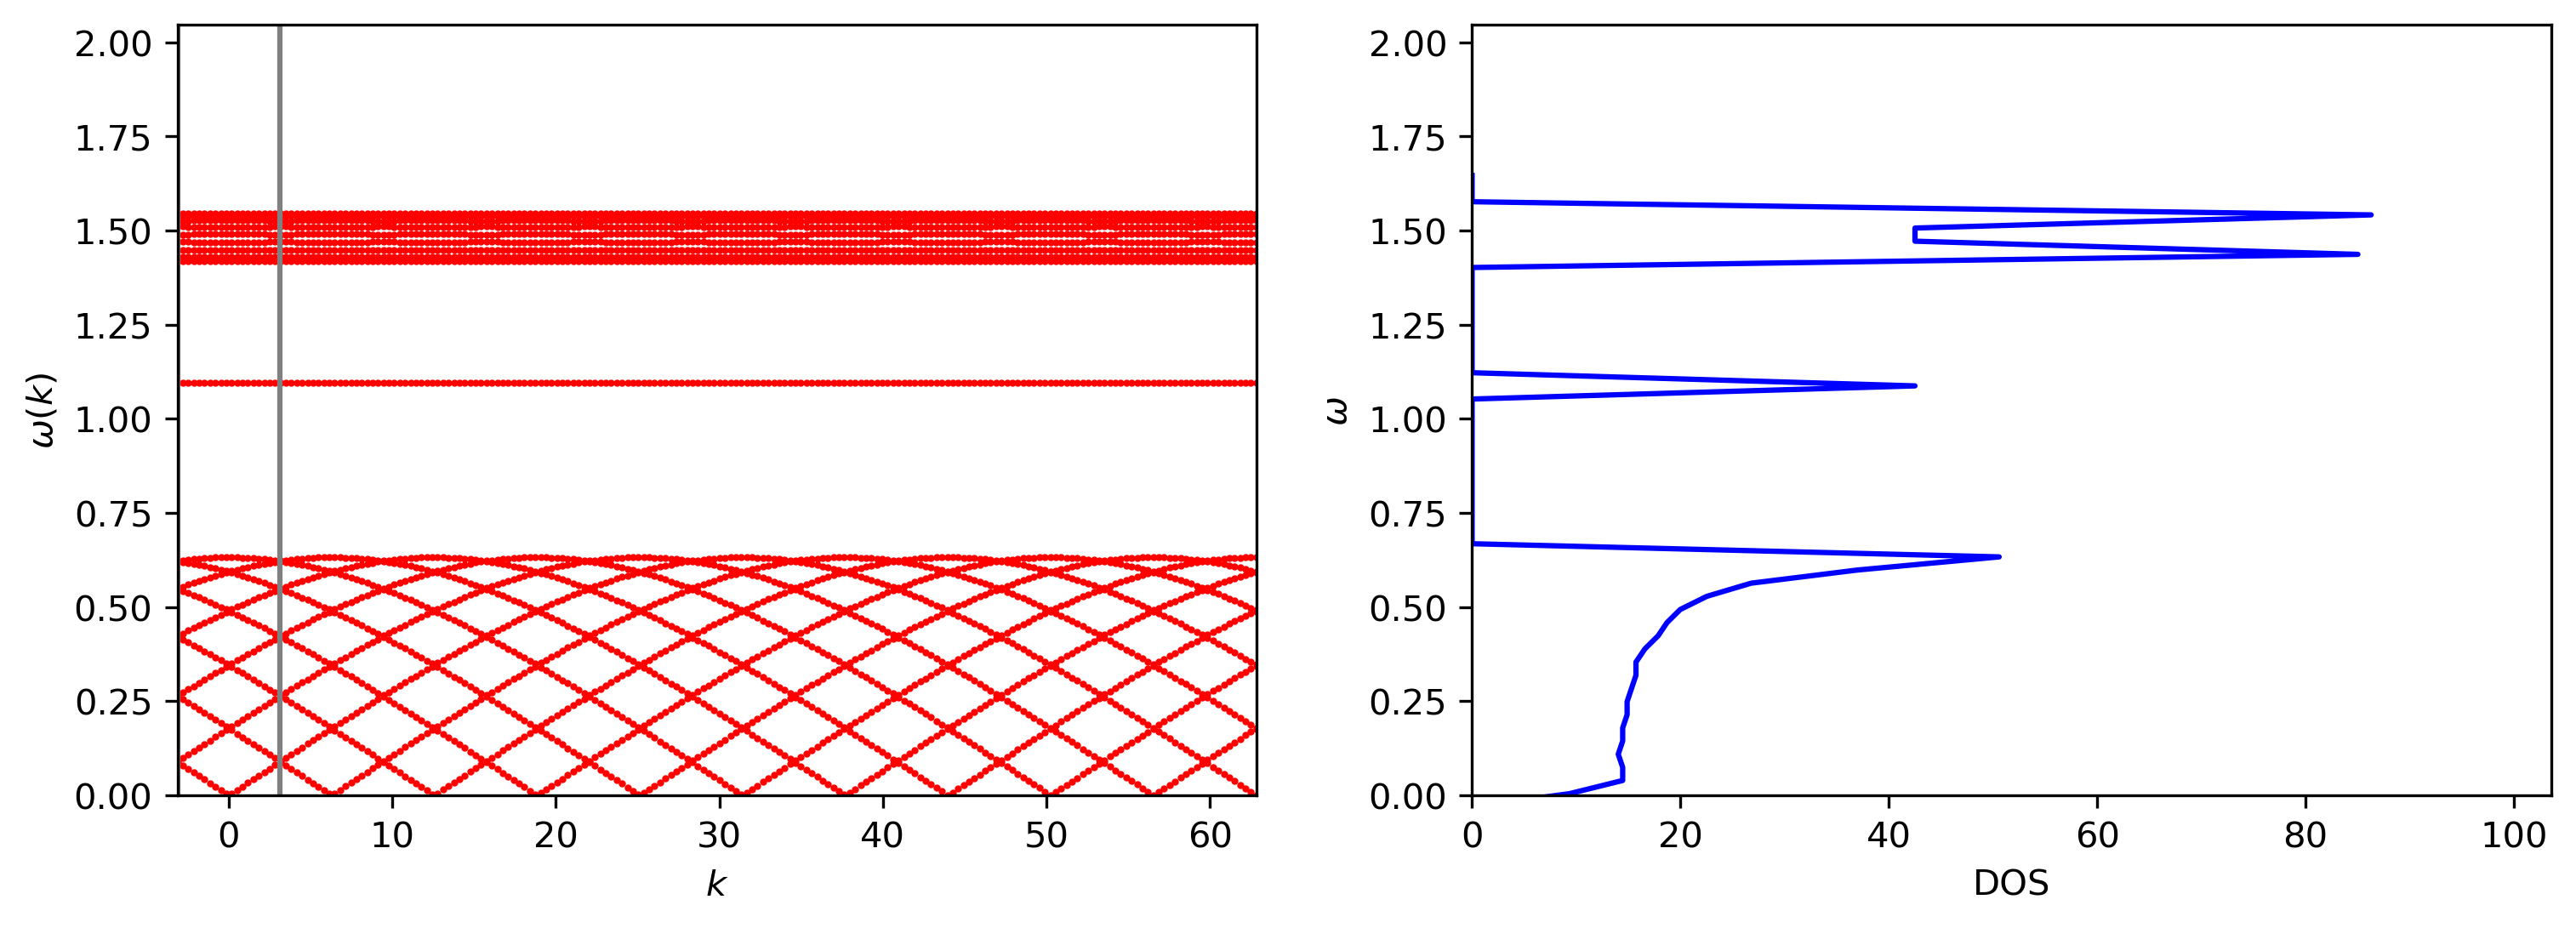

In [6]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize.nonlin import BroydenFirst, KrylovJacobian
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
from numpy import linalg as LA
from pylab import *

########################################
#                                      #
#        Part 1: set parameters        #
#                                      #
########################################

factor = 50
#if factor %2 > 0:
#    factor = factor - 1
#C = [4.] * factor
#M = [1.] * factor
#for i in range(factor):
#    if i%2 != 0:
#        M[i] = 5.
#M[0] = 2.

M = [1, 5]*10
C = [1, 1]*10

M[0] = 2

if (len(M) != len(C)):
    print ('Numbers of atoms and bonds not OK ! \nScript stopped')
    exit()
else:
    print ('Numbers of atoms and bonds OK !\n')

a = 1.0

N = len(M) 

print ('M = ' + str(M) + '\n' + 'C = ' + str(C) + '\n')
print ('Number of atoms: ' + str(N) + '\n')

########################################
#                                      #
#      Part 2: functions returning     #
#   the dynamical matrix and the DOS   #
#                                      #
########################################

def dyn_mat_Nat(k):
    diag_dyn_mat = np.zeros(shape=(N), dtype=float)
    for l in range(N):
        if l == 0:
            diag_dyn_mat[l] = (C[N-1]+C[0])
        else:
            diag_dyn_mat[l] = (C[l]+C[l-1])
            
    matrix = np.zeros(shape=(N,N), dtype=complex)
    for i in range(N):
        for j in range(N):
            sum = 0.
            if i == j:
                sum = diag_dyn_mat[i]
            elif i > j:
                if abs(j-i) == 1:
                    sum = -C[i-1]
                if abs(j-i) == N-1:
                    sum = -C[i]*np.exp(-1.j*k*a)            
            matrix[i,j] = (1/sqrt(M[i]*M[j]))*sum
    for i in range(N):
        for j in range (N):
            if i < j:
                matrix[i,j] = np.conj(matrix[j,i])
    return matrix

def dos_w(solution,N):
    # For each frequencies w, we integrate the number of state between w-dw and w+dw
    # Only the solution within the Brillouin zone must be provided
    solution_list = list(flatten(solution))

    dw = 3e-2
    nw = int(max(solution_list)/dw)
    w_space = np.linspace(-0.1,max(solution_list)+0.1,nw)
    w_dos = []

    for w in w_space:
        wsum = 0.
        for i in solution_list:
            if i > w-dw/2 and i < w+dw/2:
                wsum += 1
        w_dos.append(wsum)

    # Normalize the DOS so that the integral over the Brillouin zone is N !
    w_sum = sum(w_dos)*dw
    w_dos = w_dos/(w_sum/N)
    w_sum = sum(w_dos)*dw
    return w_space,w_dos,w_sum


#print (dyn_mat_Nat(0))
print ("")


# Building a N x N matrix:
#matrix = np.zeros(shape=(N,N))
#print (matrix)       

########################################
#                                      #
#      Part 3: diagonalizing the       #
#   dynamical matrix on a mesh in      #
#    k-space and computing the DOS     #
#  using the eigenvalues restricted to #
#      the first Brillouin zone        #
#                                      #
########################################

nk = 200 # number of points in the reciprocal space

# k points
kmesh = np.linspace(-np.pi,N*np.pi,nk)
solution, kokay = [], []
for i in range(N):
    solution.append([])
    kokay.append([])

for i in range(N):
    for k in kmesh:
        n = LA.eigvalsh(dyn_mat_Nat(k))
        if np.real(n[i]) > 0:
            solution[i].append(np.sqrt(np.real(n[i])))
            kokay[i].append(k)
            
# Finding max frequency:
max_w = max(list(flatten(solution)))

# Calculation the DOS

print('Calculating the DOS...')

ibz, solution_ibz, kokay_ibz =   np.linspace(-np.pi/a,np.pi/a,nk), [], []
for i in range(N):
    solution_ibz.append([])
    kokay_ibz.append([])

for i in range(N):
    for k in ibz:
        n = LA.eigvalsh(dyn_mat_Nat(k))
        if np.real(n[i]) > 0:  
            solution_ibz[i].append(np.sqrt(np.real(n[i])))
            kokay_ibz[i].append(k)

results_dos = [dos_w(solution_ibz,N)[0],\
               dos_w(solution_ibz,N)[1],\
               dos_w(solution_ibz,N)[2]]            

print('Integrated DOS = ' + '%.2f'%(results_dos[2]))

########################################
#                                      #
#     Part 4: Plotting the results     #
#                                      #
########################################

plt.figure(figsize=(12, 4), dpi=300) 
plt.subplot(1,2,1,adjustable='datalim')
for i in range(N):
    plt.plot(kokay[i],solution[i],'ro',ms=1.)
    
plt.xlabel(r'$k$')
plt.ylabel(r'$\omega (k)$')
plt.xlim(-np.pi/a,N*np.pi/a)
plt.axvline(x=np.pi/a, c='gray')
plt.axvline(x=-np.pi/a, c='gray')
plt.ylim(0,max_w+0.5)

plt.subplot(1,2,2,adjustable='datalim')
plt.xlabel(r'DOS')
plt.ylabel(r'$\omega$')
plt.ylim(0,max_w+0.5)
plt.xlim(0,max(results_dos[1])+max(results_dos[1])/5)
plt.plot(results_dos[1],results_dos[0], 'b', ms= 0.5)
plt.savefig("1D_N-atoms_chain_vibrations.pdf")

print ('')

## IV) Beyond

The following is optional: we mainly address some aspect found dealing with real materials.

### a) Dispersion curves for aluminium (fcc lattice)

In this exercice, we start with a real material, aluminium, which crystallizes as a ${fcc}$ lattice. 
In the previous exercices, we established for models compounds the dispersion curves based on the atomic masses and the interatomic force constants. Another possibility is to calculate the force constants from an appropriate theoretical framework.

In the following, the force constants of $fcc$-Al are calculated through effective medium theory (EMT), and you can tune the lattice parameter $a$. Depending on the volume of the unit cell, imaginary frequencies may appear.

#### <span style="color: #0000ff;">Exercises and questions</span>

<p><span style="color: #0000ff;">What is the interval of volumes for which $fcc$-Al is dynamically stable within EMT ?</span> </p>



In [1]:
%run Al_ase_phonons.py

interactive(children=(FloatSlider(value=4.05, description='a (Angstrom)', max=10.0), Button(description='Run I…

### b) Vibration spectrum from Density Functional Theory

Density functional theory (DFT) is a widely spread method to compute properties of real materials from first principles (i.e. the fundamental laws of electromagnetism and quantum mechanics): without going into details, this method allows one to access properties of real materials by solving a Schrödinger equation, explicitly accounting the electronic structure of materials.

The following script perform a DFT calculation for crystaline silicon: after computing the electronic structure of silicon, the code calculate the interatomic forces to build the dynamical matrix, then diagonalizes it to compute the eigenvalues and the density of state. 

#### <span style="color: #0000ff;">Exercises and questions</span>

<p><span style="color: #0000ff;">In the output, find the frequencies at the center of the Brillouin zone ($\Gamma$), and try to plot the DOS.</span> </p>

In [2]:
%run Si_DFT_gpaw_vibrations.py


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  19.8.1
 |___|_|             

User:   slemal@slemal-ULg
Date:   Wed Mar  4 11:27:31 2020
Arch:   x86_64
Pid:    32335
Python: 3.7.5
gpaw:   /home/slemal/anaconda3/lib/python3.7/site-packages/gpaw
_gpaw:  /home/slemal/anaconda3/lib/python3.7/site-packages/
        _gpaw.cpython-37m-x86_64-linux-gnu.so
ase:    /home/slemal/.local/lib/python3.7/site-packages/ase (version 3.19.0)
numpy:  /home/slemal/anaconda3/lib/python3.7/site-packages/numpy (version 1.17.4)
scipy:  /home/slemal/anaconda3/lib/python3.7/site-packages/scipy (version 1.3.2)
libxc:  3.0.0
units:  Angstrom and eV
cores:  1

Input parameters:
  kpts: {size: (4, 4, 4)}
  mode: {ecut: 300.0,
         gammacentered: False,
         name: pw}

[Phonopy] Atomic displacements:
[Phonopy] 0 [0.029999999999999995, 0.0, 0.0]
System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

Si-setup:
  name: Silicon
  

In [36]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read() #or edit path to custom.css
    return HTML(styles)
css_styling()

#import json
#s = json.load( open("bmh_matplotlibrc.json") )  #edit path to json file
#matplotlib.rcParams.update(s)